In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=be6e2887ec4b0afcccd3663852361db8cab06fb1f6159c5c6a72a7ff348a77c8
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, to_timestamp, when, expr
from pyspark.sql.types import DoubleType
from google.colab import drive
import shutil 
import os
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up PySpark
spark = SparkSession.builder.appName("CyclingAnalysis").getOrCreate()

In [4]:
# Connect to Google drive to extract csv files from dataset zip file 
drive.mount('/content/drive/')
shutil.unpack_archive("/content/drive/MyDrive/BDA_Datasets/cyclehireusagestats-2014.zip", "/content/Dataset/")

dataset_path = "/content/Dataset/"
file_list = os.listdir(dataset_path)
dataset_files = [os.path.join(dataset_path, file) for file in file_list]


Mounted at /content/drive/


In [5]:
# Create a list of csv file names to iterate over
csv_files = [file for file in dataset_files if file.endswith('.csv')]
print(csv_files)

# Read and combine the CSV files into a single DataFrame
df = None
for csv_file in csv_files:
    # Select only first 9 columns in order to avoid garbage columns 
    temp_df = spark.read.option("header", "true").csv(csv_file).select(spark.read.option("header", "true").csv(csv_file).columns[:9])
    # Typecast the duration column to be Double
    temp_df = temp_df.withColumn("Duration", col("Duration").cast(DoubleType()))
    # Drop rows where start date is null 
    temp_df = temp_df.na.drop(subset=["Start Date"])
    # Convert Start Date to timestamp
    temp_df = temp_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm"))
    temp_df = temp_df.withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))
    # Swap start date and end date if duration is negative
    temp_df = temp_df.withColumn("Swapped Date", when(col("Duration") < 0, col("Start Date")).otherwise(col("End Date")))
    temp_df = temp_df.withColumn("Start Date", when(col("Duration") < 0, col("End Date")).otherwise(col("Start Date")))
    temp_df = temp_df.withColumn("End Date", when(col("Duration") < 0, col("Swapped Date")).otherwise(col("End Date"))).drop("Swapped Date")

     # Calculate duration as the difference between end and start dates
    temp_df = temp_df.withColumn("Duration", expr("(unix_timestamp(`End Date`) - unix_timestamp(`Start Date`))"))

    if df is None:
        df = temp_df
    else:
        # Join the temp dataframe with the current dataset 
        df = df.union(temp_df)


['/content/Dataset/9a Journey Data Extract 17Aug14-31Aug14.csv', '/content/Dataset/1. Journey Data Extract 05Jan14-02Feb14.csv', '/content/Dataset/10b. Journey Data Extract 28Sep14-11Oct14.csv', '/content/Dataset/2. Journey Data Extract 03Feb14-01Mar14.csv', '/content/Dataset/9b Journey Data Extract 01Sep14-13Sep14.csv', '/content/Dataset/11a. Journey Data Extract 12Oct14-08Nov14.csv', '/content/Dataset/8a Journey Data Extract 20Jul14-31Jul14.csv', '/content/Dataset/13a. Journey Data Extract 07Dec14-21Dec14.csv', '/content/Dataset/7. Journey Data Extract 22Jun14-19Jul14.csv', '/content/Dataset/6. Journey Data Extract 25May14-21Jun14.csv', '/content/Dataset/12a. Journey Data Extract 09Nov14-06Dec14.csv', '/content/Dataset/8b Journey Data Extract 01Aug14-16Aug14.csv', '/content/Dataset/4. Journey Data Extract 01Apr14-26Apr14.csv', '/content/Dataset/13b. Journey Data Extract 22Dec14-03Jan15.csv', '/content/Dataset/3. Journey Data Extract 02Mar14-31Mar14.csv', '/content/Dataset/11b. Journe

In [6]:
# Explore and visualize the data
df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: long (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [7]:
# Perform exploratory data analysis (EDA) to gain insights
df.describe().show()

+-------+--------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+
|summary|           Rental Id|          Duration|           Bike Id|     EndStation Id|     EndStation Name|   StartStation Id|   StartStation Name|
+-------+--------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+
|  count|            10242483|          10242483|          10242483|          10242351|            10242351|          10242483|            10242483|
|   mean|3.4862637579402864E7|1466.1368283452362| 6712.062896858115| 320.5373222417392|                null| 321.1881879618448|                null|
| stddev|   3169119.883330912|12946.831876201535|3719.8446340975524|210.26335159599523|                null|210.81468800069445|                null|
|    min|            29340869|                 0|                 1|                 1|Abbey Orchard Str..

In [8]:
# Top 20 rows in dataframe
df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
| 36389367|     300|   4107|2014-08-17 00:05:00|          206|New Road 1 , Whit...|2014-08-17 00:00:00|            444|Bethnal Green Gar...|
| 36389361|    1140|   3763|2014-08-17 00:19:00|          186|South Wharf Road,...|2014-08-17 00:00:00|            713|Hawley Crescent, ...|
| 36389355|     120|   2284|2014-08-17 00:02:00|          432|Exhibition Road M...|2014-08-17 00:00:00|            428|Exhibition Road, ...|
| 36389352|     360|    446|2014-08-17 00:06:00|          433|Wren Street, Holborn|2014-08-17 00:00:00|            436|Red Lion Street, ...|
| 36389372|  

In [9]:
# Filter the data for Spring (March, April, May)
spring_df = df.filter((month(col("Start Date")) >= 3) & (month(col("Start Date")) <= 5))

# Filter the data for Autumn (September, October, November)
autumn_df = df.filter((month(col("Start Date")) >= 9) & (month(col("Start Date")) <= 11))

# Calculate the average duration of rides for Spring and Autumn
spring_avg_duration = spring_df.agg({"Duration": "avg"}).collect()[0][0]
autumn_avg_duration = autumn_df.agg({"Duration": "avg"}).collect()[0][0]


In [10]:
autumn_df.filter(col("Duration")==0).show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
| 37876147|       0|  11133|2014-09-28 00:16:00|          406|Speakers' Corner ...|2014-09-28 00:16:00|            406|Speakers' Corner ...|
| 37876224|       0|   2627|2014-09-28 00:21:00|           18|Drury Lane, Coven...|2014-09-28 00:21:00|             18|Drury Lane, Coven...|
| 37876509|       0|  10887|2014-09-28 00:37:00|          480|Flamborough Stree...|2014-09-28 00:37:00|            480|Flamborough Stree...|
| 37876583|       0|   1936|2014-09-28 00:42:00|          149|Kennington Road P...|2014-09-28 00:42:00|            149|Kennington Road P...|
| 37876974|  

In [11]:
spring_df.filter(col("Duration")<0).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+



H0 (Null Hypothesis): In 2014, people ride for longer in Autumn than in Spring

H1 (Alternative Hypothesis): In 2014, people ride for longer in Spring than in Autumn

In [12]:
# Extract the duration values from the DataFrames
spring_durations = spring_df.select("Duration").rdd.flatMap(lambda x: x).collect()
autumn_durations = autumn_df.select("Duration").rdd.flatMap(lambda x: x).collect()

# Check if spring_durations and autumn_durations contain numerical values
spring_durations = [float(duration) for duration in spring_durations]
autumn_durations = [float(duration) for duration in autumn_durations]

# Check if spring_durations and autumn_durations are non-empty
if len(spring_durations) == 0 or len(autumn_durations) == 0:
    print("One or both datasets have empty 'Duration' columns.")
else:
    # Perform a two-sample independent t-test
    t_statistic, p_value = ttest_ind(spring_durations, autumn_durations, equal_var=False)
    
    # Check if t-statistic and p-value are NaN
    if np.isnan(t_statistic) or np.isnan(p_value):
        print("Invalid t-statistic or p-value. Check your data.")
    else: 
        print("T-Statistic:", t_statistic)
        print("P-Value:", p_value)

T-Statistic: 14.293192098054327
P-Value: 2.4179790215678895e-46


### Since the p-value is extremely small (p<0.05), we can reject the null hypothesis (H0). This suggests strong evidence to support the alternative hypothesis (H1) that the average duration of bicycle rides during Spring in 2014 is longer than during Autumn.


In [13]:
print("Spring avg duration: ",spring_avg_duration)
print("Autumn Avg duration : ",autumn_avg_duration)

Spring avg duration:  1515.2960927167885
Autumn Avg duration :  1352.6149131458556


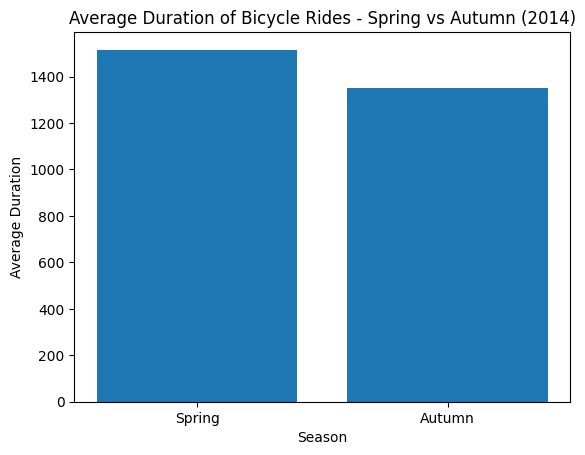

In [14]:
# Bar Chart visualizing the comparison of average duration between spring and autumn 
seasons = ["Spring", "Autumn"]
avg_durations = [spring_avg_duration, autumn_avg_duration]

plt.bar(seasons, avg_durations)
plt.xlabel("Season")
plt.ylabel("Average Duration")
plt.title("Average Duration of Bicycle Rides - Spring vs Autumn (2014)")
plt.show()

### As the calculated value reaffirms the conclusion from the statistical analysis, therefore we conclude,  “In 2014, people ride for longer in Spring than in Autumn”  